In [1]:
import os
import glob
import datetime
import numpy as np
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import * #sortData, starLocate, nircEPSF, calcBinDist

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\clio_astro\\reduced'
Clio_datasets = sortData(datadir, filesdeep='')

  1%|▉                                                                              | 14/1213 [00:00<00:08, 133.33it/s]

sorting individual images


100%|███████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 10999.49it/s]

sorting unique datasets into lists


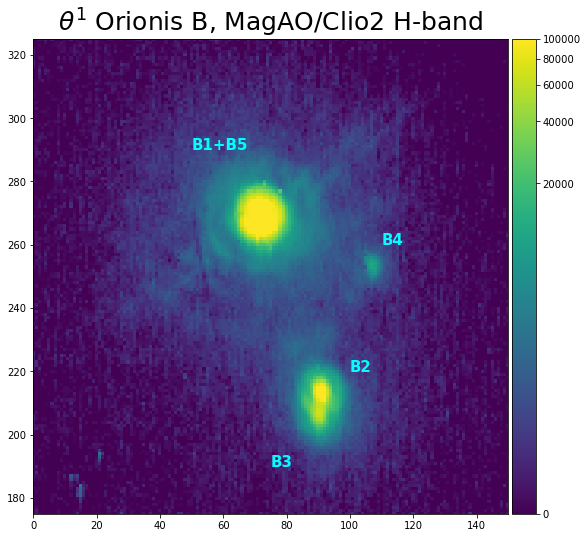

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.figure(figsize=(9,9))
ax = plt.gca()
im = ax.imshow(fits.getdata(Clio_datasets[0][12][0]), norm=ImageNormalize(stretch=AsinhStretch(a=0.01), vmin=0, vmax=100000), origin='lower')
ax.set_xlim(0,150)
ax.set_ylim(175,325)
plt.annotate(xy=[50,290], s='B1+B5', c='cyan', size=15, weight='bold')
plt.annotate(xy=[110,260], s='B4', c='cyan', size=15, weight='bold')
plt.annotate(xy=[100,220], s='B2', c='cyan', size=15, weight='bold')
plt.annotate(xy=[75,190], s='B3', c='cyan', size=15, weight='bold')
plt.title(r'$\theta^1$ Orionis B, MagAO/Clio2 H-band', size=25)
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.savefig('tet1oriB_Clio.png', dpi=150, transparent=True)

In [10]:
# 0: baades 1, 11
# 1: baades H 1, 5
# 2: Trap 127 - blank
# 3: trap31 1, 6 - good 2019-11-06
# 4: trap33 1, 6 - good 2019-11-06
# 5: Trap33 36 - blank
# 6: trap39 1, 6 - good 2019-11-06
# 7: trapb1 1, 3 - bad
# 8: trapbrg 1, 6 - good 2019-11-06
# 9: Trapcal 12 - blank
# 10: Trapezium 1, 6 - need less coadding (do indiv imgs) 2014-04-11
# 11: Trapezium 41, 46 - need less coadding 2014-04-11
# 12: traph 1, 6 - good 2019-11-06
# 13: trapj 1, 6 - good 2019-11-06
# 14: trapks 1, 6 - good 2019-11-06
# 15: TrapK 1, 21 - need less coadding 2014-11-17
# 16: TrapK 34, 54, 74 - need less coadding 2014-11-17 
# 17: TrapL 1, 11 - need less coadding (good for distor map) 2014-11-17
# 18: trapl 1, 6 - good 2019-11-06
# 19: trapm 1, 6 - good 2019-11-06
# 20: TrapM 238 - blank
# 21: Trap 1, 6, 11 - bad
goodClioTrap = Clio_datasets[0][10:11]#Clio_datasets[0][3:5]+Clio_datasets[0][6:7]+Clio_datasets[0][8:9]+Clio_datasets[0][12:15]+Clio_datasets[0][18:20]

Choose a reference star image to create a reference PSF from


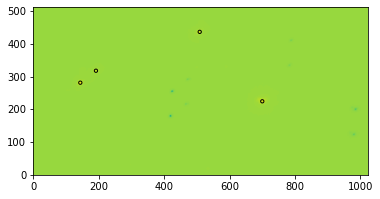

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
 699.7649003921523 224.32179184278235 0.12389422730967466
143.20659177288633  281.2130129159989  0.2130508933602954
191.05491818942278  317.7832658005413 0.29279448326020524
508.39897748698695 436.65996909899604 0.06371164665791605
input the 0 indexed integer of your target from the table above: 1
target star is at  143 , 281  at FWHM 8.457101286620826


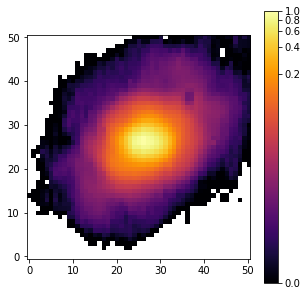

Select your target system to fit positions to


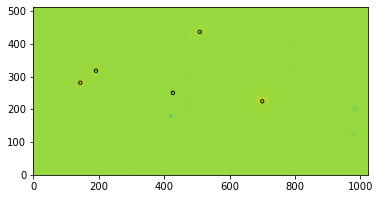

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
 699.7649003921523 224.32179184278235 0.12389422730967466
426.38807433605024  249.8569365950976  0.4367310714944461
143.20659177288633  281.2130129159989  0.2130508933602954
191.05491818942278  317.7832658005413 0.29279448326020524
508.39897748698695 436.65996909899604 0.06371164665791605
input the 0 indexed integer of your target from the table above: 3
target star is at  191 , 317  at FWHM 10.147163209517856
Stars found at positions
       x_0                y_0       
------------------ -----------------
38.745467549845586 38.71543806160744
       x_0                y_0       
------------------ -----------------
47.435343864283325 40.33255614465958

9.058751575377261 +/- 0.11745431678317587
277.3816230525498 +/- 1.2837112707522351
Choose a reference star image to create a reference PSF from


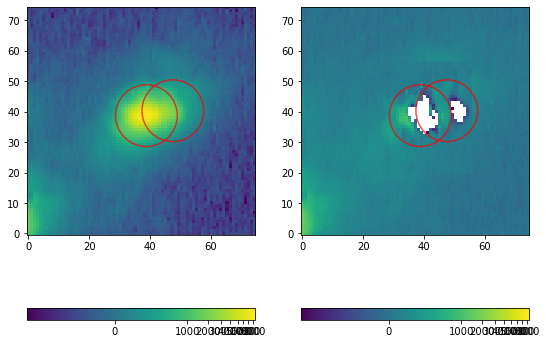

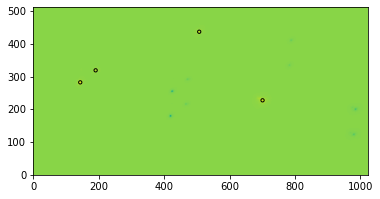

    xcentroid          ycentroid           roundness      
------------------ ------------------ --------------------
 700.6117283315361 227.30461878746388  0.25304550758339794
143.01184884320307  282.2603056200493 0.047085797940114124
 190.0718711317488  319.0331795692236  0.11723028654520982
506.86751875079375  437.0349678978464  0.11514754331051161
input the 0 indexed integer of your target from the table above: 1
target star is at  143 , 282  at FWHM 5.823975355646326


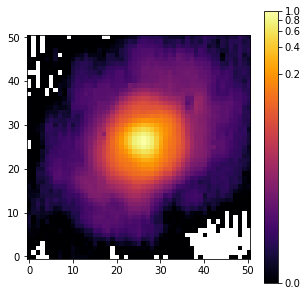

Select your target system to fit positions to


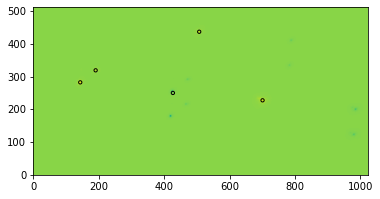

    xcentroid          ycentroid           roundness      
------------------ ------------------ --------------------
 700.6117283315361 227.30461878746388  0.25304550758339794
 426.3913852446494  249.8567969473611  0.43764637393999734
143.01184884320307  282.2603056200493 0.047085797940114124
 190.0718711317488  319.0331795692236  0.11723028654520982
506.86751875079375  437.0349678978464  0.11514754331051161
input the 0 indexed integer of your target from the table above: 3
target star is at  190 , 319  at FWHM 6.353795847875972
Stars found at positions
       x_0               y_0        
----------------- ------------------
38.92354637141867 37.824454268118906
       x_0               y_0        
----------------- ------------------
46.51586825847122 38.668683655699496

7.621511909450329 +/- 0.06560315450534553
275.58106891977707 +/- 1.2909151656672293
Choose a reference star image to create a reference PSF from


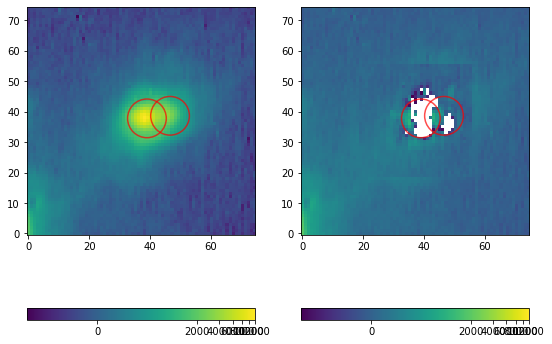

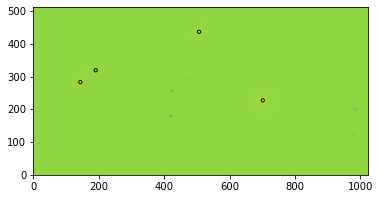

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
 701.2095623857334 227.24799598643267  0.2597674085455993
143.21401931092112 282.86631585514425  0.2869350446408968
190.29295633386553  319.2189804577922  0.2408141700162829
506.40224343356437 436.86665487915013 0.08857581458719539


In [ ]:
data_frames = []
for dataset in goodClioTrap:
    data = []
    dates = []
    filts = []
    for image in dataset:
        phot_results = ClioLocate(image, 1000, 5, 5, stampsize=75, epsfstamp=51, roundness=1, iterations=2, crit_sep=15, setfwhm=5)
        data.append(phot_results)
        date = fits.getheader(image)['DATE']
        filt = fits.getheader(image)['PASSBAND']
        dates.append(date)
        filts.append(filt)
    data2 = np.asarray(data)
    data_frame = pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr'])
    data_frame['date'] = dates
    data_frame['filter'] = filts
    data_frames.append(data_frame)

In [38]:
data_frames

[         sep    seperr          PA     PAerr                 date  filter
 0  38.719072  1.052191   52.447149 -3.139222  2019-11-06T03:20:22  MKO M'
 1   9.024880  0.228196  167.177597  1.263571  2019-11-06T03:20:22  MKO M']

In [39]:
data_frames[0].to_clipboard()

In [41]:
goodClioTrap[8]

['C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\clio_astro\\reduced\\coadds\\trapm_00001_LBP_nodsub_COADD.fit.gz',
 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\clio_astro\\reduced\\coadds\\trapm_00006_LBP_nodsub_COADD.fit.gz']